In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tessrip import Rip
from tess_asteroid_ml.make_TESS_asteroid_db import *
from tess_asteroid_ml import PACKAGEDIR
from sklearn.preprocessing import QuantileTransformer
from astropy.stats import sigma_clip

In [2]:
sector = 2
camera = 1 
ccd = 1

SAT_LEVEL = 2e5

In [3]:
rips = Rip(sector=sector, camera=camera, ccd=ccd)

In [4]:
flux, _ = rips.get_flux(shape=(100, 100))

In [5]:
nt, nr, nc = flux.array.shape

In [68]:
qmask = rips.quality.array == 0

In [6]:
mean_flux = np.mean(flux.array.reshape((nt, nr * nc)), axis=-1)

In [79]:
pcen = np.percentile(mean_flux, [0,1,50,99,100], interpolation="nearest")
cad_pcen = [np.abs(mean_flux-x).argmin() for x in pcen]
pcen, cad_pcen

(array([138.26324, 138.76924, 140.36127, 377.24957, 405.1725 ],
       dtype=float32),
 [986, 1082, 128, 1226, 1221])

In [83]:
pcen = np.percentile(mean_flux[qmask], [0,1,50,99,100], interpolation="nearest")
cad_pcen = [np.abs(mean_flux[qmask]-x).argmin() for x in pcen]
pcen, cad_pcen

(array([138.75168, 138.77626, 140.43205, 366.62143, 405.1725 ],
       dtype=float32),
 [1042, 1029, 126, 1166, 1175])

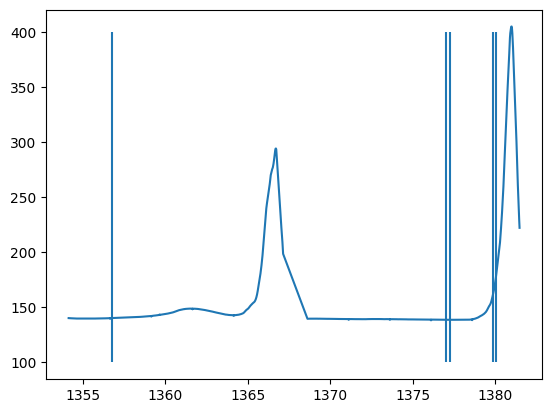

In [84]:
plt.plot(rips.time.array, mean_flux)
plt.vlines(rips.time.array[cad_pcen], ymin=100, ymax=400)
plt.show()

In [9]:
def get_FFI_path(file_name, provider="mast"):
    
    if provider == "mast":
        root_path = "https://archive.stsci.edu/missions/tess"
    elif provider == "aws":
        root_path = "s3://stpubdata/tess/public"

    aux = []
    for fn in file_name:
        date_o = fn[4:17]
        yyyy = date_o[:4]
        ddd = date_o[4:7]
        camera = fn.split("-")[2]
        ccd = fn.split("-")[3]
        dir_path = f"ffi/s{sector:04}/{yyyy}/{ddd}/{camera}-{ccd}"
        aux.append(f"{root_path}/{dir_path}/{fn}")

    file_name = aux

    return file_name

In [80]:
np.array(rips.ffi_names)[cad_pcen]

array(['tess2018257142940-s0002-1-1-0121-s_ffic.fits',
       'tess2018259142940-s0002-1-1-0121-s_ffic.fits',
       'tess2018238062941-s0002-1-1-0121-s_ffic.fits',
       'tess2018262142940-s0002-1-1-0121-s_ffic.fits',
       'tess2018262115940-s0002-1-1-0121-s_ffic.fits'], dtype='<U44')

In [76]:
files = np.array(rips.ffi_names)[qmask][cad_pcen]
files

array(['tess2018259115940-s0002-1-1-0121-s_ffic.fits',
       'tess2018259045940-s0002-1-1-0121-s_ffic.fits',
       'tess2018238075941-s0002-1-1-0121-s_ffic.fits',
       'tess2018262072940-s0002-1-1-0121-s_ffic.fits',
       'tess2018262115940-s0002-1-1-0121-s_ffic.fits'], dtype='<U44')

In [77]:
ffi_file = get_FFI_path(files)

In [78]:
ffi_header, f2d, col_2d, row_2d, ra_2d, dec_2d = get_data_from_files(
        ffi_file, provider="mast"
    )
f2d = np.asarray(f2d)

Set MJD-END to 58377.525639 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 58377.233980 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 58356.359232 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 58380.338058 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 58380.525553 from DATE-END'. [astropy.wcs.wcs]


In [85]:
f2d.max(), f2d.min()

(124611.2, -61.596996)

In [86]:
qt = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')

flux_raw = f2d[0]
flux_log = np.log10(flux_raw)

qt.fit(f2d.flatten().reshape(-1, 1))
flux_quant = qt.transform(flux_raw.flatten().reshape(-1, 1)).reshape(flux_raw.shape)

/var/folders/lz/gmp0cdwx3_v5v7qww7r6sg100000gn/T/ipykernel_34627/3738488415.py:4: RuntimeWarning: invalid value encountered in log10
  flux_log = np.log10(flux_raw)


In [87]:
flux_quant.min(), flux_quant.max()

(0.0, 1.0)

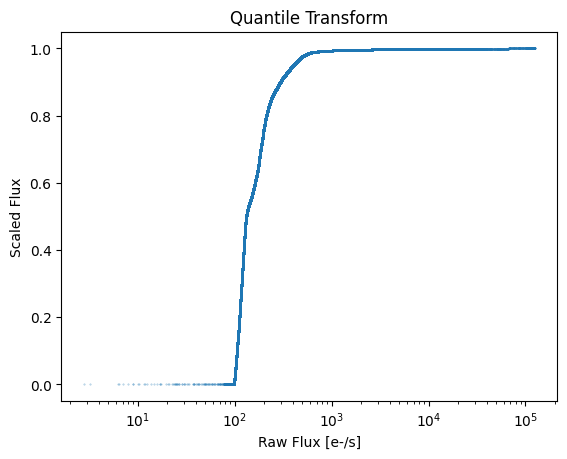

In [88]:
plt.scatter(flux_raw.ravel(), flux_quant.ravel(), marker=".", s=.5, alpha=.5)
plt.xscale("log")
plt.title("Quantile Transform")
plt.xlabel("Raw Flux [e-/s]")
plt.ylabel("Scaled Flux")
plt.show()

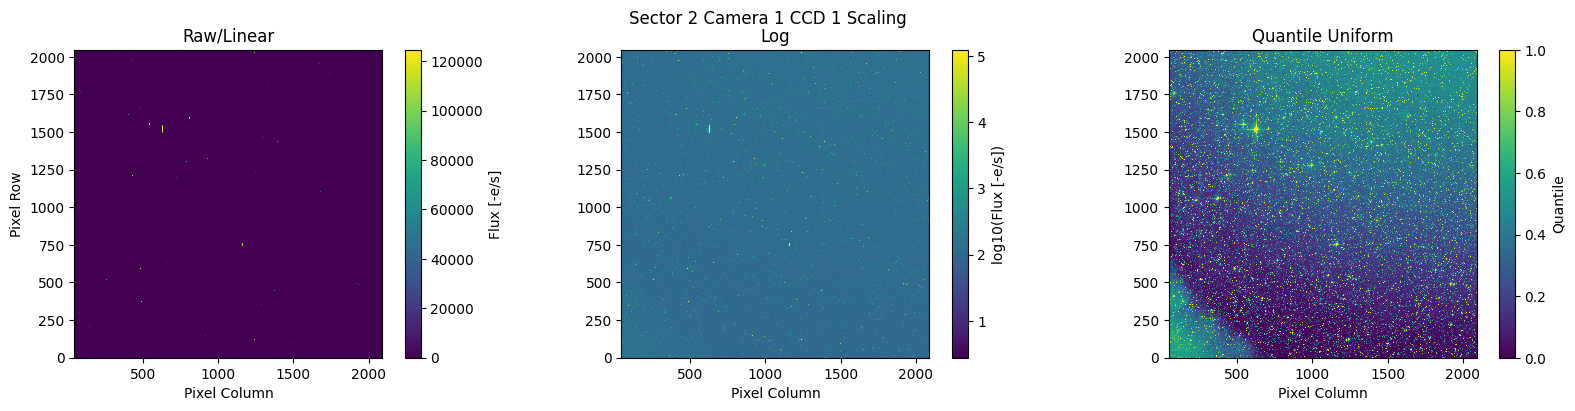

In [89]:
# vlo, lo, mid, hi, vhi = np.nanpercentile(flx.array[cad] - statics, [0.2, 1, 50, 95, 99.8])


fig, ax = plt.subplots(1, 3, figsize=(20,4))
fig.suptitle(f"Sector {sector} Camera {camera} CCD {ccd} Scaling")

ax[0].set_title("Raw/Linear")
im = ax[0].pcolormesh(
    col_2d, row_2d,
    flux_raw, 
    cmap="viridis",
    # vmin=vlo, 
    # vmax=vhi,
)
plt.colorbar(im, ax=ax[0], location="right", shrink=1, label="Flux [-e/s]")

ax[1].set_title("Log")
im = ax[1].pcolormesh(
    col_2d, row_2d,
    flux_log, 
    cmap="viridis",
    # vmin=vlo, 
    # vmax=vhi,
)
plt.colorbar(im, ax=ax[1], location="right", shrink=1, label="log10(Flux [-e/s])")

ax[2].set_title("Quantile Uniform")
im = ax[2].pcolormesh(
    col_2d, row_2d,
    flux_quant, 
    cmap="viridis",
    # vmin=vlo, 
    # vmax=vhi,
)
plt.colorbar(im, ax=ax[2], location="right", shrink=1, label="Quantile")

ax[0].set_xlabel("Pixel Column")
ax[1].set_xlabel("Pixel Column")
ax[2].set_xlabel("Pixel Column")
ax[0].set_ylabel("Pixel Row")

ax[0].set_aspect('equal', 'box')
ax[1].set_aspect('equal', 'box')
ax[2].set_aspect('equal', 'box')

plt.show()

In [53]:
with open(f"{os.path.dirname(PACKAGEDIR)}/data/support/data_transformers/quantile_transformer_s{sector:04}-{camera}-{ccd}.pkl", "wb") as f:
    pickle.dump(qt, f)

In [54]:
with open(f"{os.path.dirname(PACKAGEDIR)}/data/support/data_transformers/quantile_transformer_s{sector:04}-{camera}-{ccd}.pkl", "rb") as f:
    qt2 = pickle.load(f)

In [55]:
qt2

QuantileTransformer()

In [56]:
flux_quant2 = qt2.transform(f2d.flatten().reshape(-1, 1)).reshape(f2d.shape)[0]

In [61]:
np.isclose(flux_quant, flux_quant2).all()

True

In [59]:
from scipy import ndimage

In [90]:
SAT_LEVEL = 1e5

In [91]:
f2d.max()

124611.2

/var/folders/lz/gmp0cdwx3_v5v7qww7r6sg100000gn/T/ipykernel_34627/212842856.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(f2d.ravel()), bins=1000, log=True)


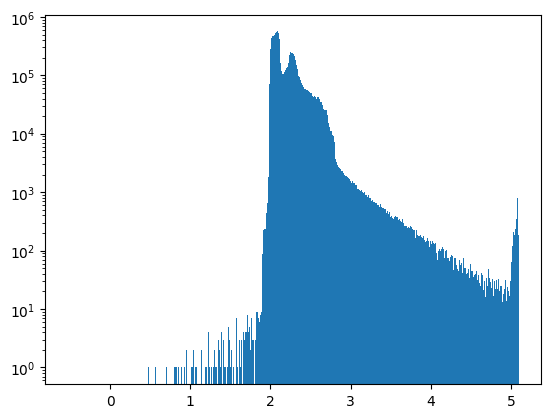

In [92]:
plt.hist(np.log10(f2d.ravel()), bins=1000, log=True)
plt.show()

In [93]:
# make sat pixel and star mask
sat_mask = (f2d >= SAT_LEVEL).any(axis=0)
sat_mask = ndimage.binary_dilation(sat_mask, iterations=3)

stack = np.median(f2d, axis=0)
star_mask = sigma_clip(stack, cenfunc="median", stdfunc="std", sigma=5).mask

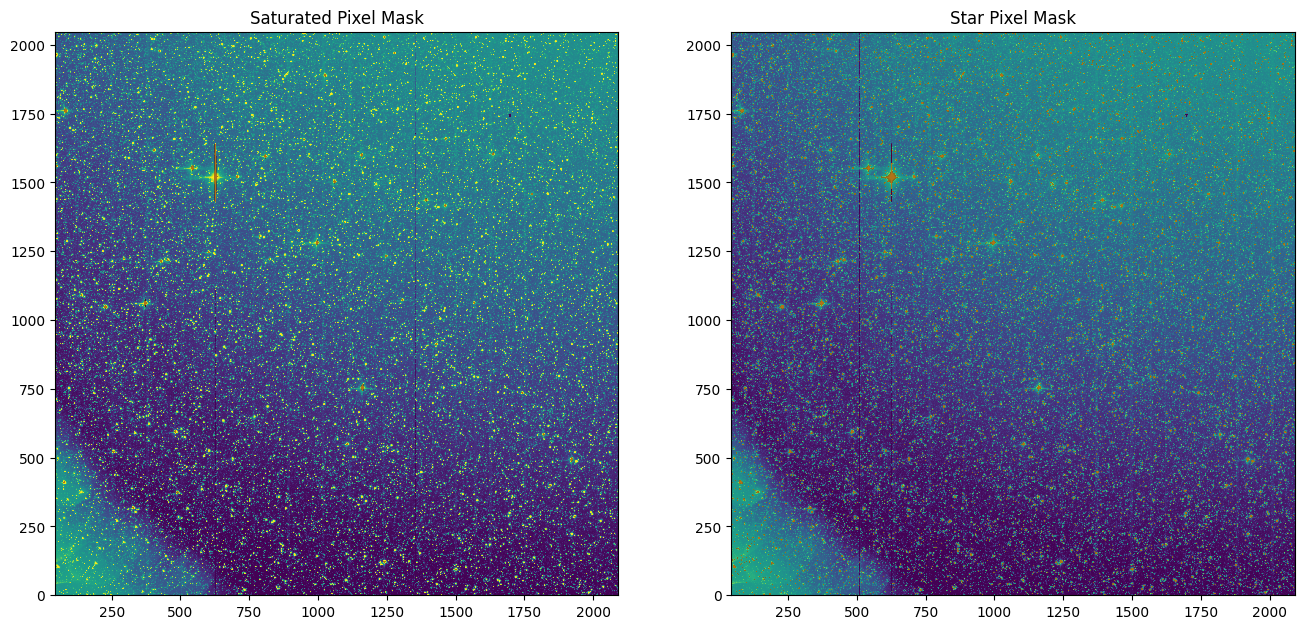

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))

sat_mask = sat_mask.astype(float)
sat_mask[sat_mask==0] = np.nan
star_mask = star_mask.astype(float)
star_mask[star_mask==0] = np.nan

ax[0].set_title("Saturated Pixel Mask")
ax[0].pcolormesh(col_2d, row_2d, flux_quant, rasterized=True)
ax[0].pcolormesh(col_2d, row_2d, sat_mask, alpha=0.5, cmap="Reds", rasterized=True, vmin=0, vmax=1)
ax[0].set_aspect('equal', 'box')

ax[1].set_title("Star Pixel Mask")
ax[1].pcolormesh(col_2d, row_2d, flux_quant, rasterized=True)
ax[1].pcolormesh(col_2d, row_2d, star_mask, alpha=0.5, cmap="Reds", rasterized=True, vmin=0, vmax=1)
ax[1].set_aspect('equal', 'box')

plt.show()